In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Model, GPT2PreTrainedModel
import pickle
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Source: https://github.com/LCS2-IIITD/Emotion-Flip-Reasoning/blob/main/Dataloaders/nlp_utils.py
import string
import nltk
import re

numbers = {
    "0":"zero",
    "1":"one",
    "2":"two",
    "3":"three",
    "4":"four",
    "5":"five",
    "6":"six",
    "7":"seven",
    "8":"eight",
    "9":"nine"
}

def remove_puntuations(txt):
    punct = set(string.punctuation)
    txt = " ".join(txt.split("."))
    txt = " ".join(txt.split("!"))
    txt = " ".join(txt.split("?"))
    txt = " ".join(txt.split(":"))
    txt = " ".join(txt.split(";"))
    
    txt = "".join(ch for ch in txt if ch not in punct)
    return txt

def number_to_words(txt):
    for k in numbers.keys():
        txt = txt.replace(k,numbers[k]+" ")
    return txt

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'_',' ',text)
    text = number_to_words(text)
    text = remove_puntuations(text)
    text = ''.join([i if ord(i) < 128 else '' for i in text])
    text = ' '.join(text.split())
    return text

In [3]:
val_data = json.load(open('../../Dataset/ERC_conversational_level/val_conversation_level.json'))
val_data_pred = val_data.copy()

test_data = json.load(open('../../Dataset/ERC_conversational_level/test_conversation_level.json'))
test_data_pred = test_data.copy()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
emotion2int = {
    'anger': 0,
    'joy': 1,
    'fear': 2,
    'disgust': 3,
    'neutral': 4,
    'surprise': 5,
    'sadness': 6
}
int2emotion = {v: k for k, v in emotion2int.items()}

In [6]:
utterance2vec = pickle.load(open('../../Dataset/Embeddings/sentence_transformer_utterance2vec_768.pkl', 'rb'))

In [7]:
MAX_CONV_LEN = 35
# Defined index 7 for padding
class ERC_Dataset_Conv_Level_Inference(Dataset):
    def __init__(self, data, utterance2vec, testing=False):
        self.data = data
        self.utterance2vec = utterance2vec
        self.testing = testing

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        conversation = self.data[idx]['conversation']
        texts = [utterance['text'] for utterance in conversation]
        if not self.testing:
            emotions = [emotion2int[utterance['emotion']] for utterance in conversation]
        text_embeddings = [torch.from_numpy(self.utterance2vec[preprocess_text(text)]) for text in texts]
                
        if(len(text_embeddings)<MAX_CONV_LEN):
            num_pads = MAX_CONV_LEN - len(text_embeddings)
            attention_mask = [1]*len(text_embeddings) + [0]*num_pads
            text_embeddings = text_embeddings + [torch.zeros(768)]*num_pads
            if not self.testing:
                emotions = emotions + [7]*num_pads # 7 is the index for padding
        else:
            text_embeddings = text_embeddings[len(text_embeddings)-MAX_CONV_LEN:]
            attention_mask = [1]*MAX_CONV_LEN
            if not self.testing:
                emotions = emotions[len(emotions)-MAX_CONV_LEN:]

        text_embeddings = torch.stack(text_embeddings)
        attention_mask = torch.tensor(attention_mask)
        if not self.testing:
            emotions = torch.tensor(emotions)

            return {
                'text_embeddings': text_embeddings,
                'attention_mask': attention_mask,
                'emotions': emotions,
                'conversation_ID': self.data[idx]['conversation_ID']
            }
        
        return {
            'text_embeddings': text_embeddings,
            'attention_mask': attention_mask,
            'conversation_ID': self.data[idx]['conversation_ID']
        }

In [8]:
class ERC_GPT2(GPT2PreTrainedModel):
    def __init__(self, config, weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.GPT2 = GPT2Model(config)
        self.classifier = nn.Linear(config.n_embd, self.num_labels)
        self.weights = weights
        self.post_init()
        

    def forward(self, inputs_embeds, attention_mask, labels=None, device='cpu'):
        outputs = self.GPT2(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        outputs = outputs.last_hidden_state
        logits, label = {}, {}
        for b in range(outputs.size(0)):
            logits[b] = [self.classifier(outputs[b][i]) for i in range(outputs.size(1)) if attention_mask[b][i] == 1]
            if(labels is not None):
                label[b] = [labels[b][i] for i in range(outputs.size(1)) if attention_mask[b][i] == 1]
        logits = [torch.stack(logits[b]) for b in range(outputs.size(0))]
        loss = None
        if labels is not None:
            label = [torch.stack(label[b]) for b in range(outputs.size(0))]
            loss = 0
            for b in range(outputs.size(0)):
                loss += nn.CrossEntropyLoss(weight=self.weights.to(device))(logits[b].to(device), label[b].to(device))
            loss /= outputs.size(0)
        return {
            'loss': loss,
            'logits': logits,
            'labels': label   
        }

In [9]:
model = torch.load('GPT2_Conv_Level.pth', map_location=device)

In [10]:
val_dataset = ERC_Dataset_Conv_Level_Inference(val_data, utterance2vec, testing=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = ERC_Dataset_Conv_Level_Inference(test_data, utterance2vec, testing=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Inference on Validation

In [11]:
model.eval()
val_pred, val_true = [], []
with torch.no_grad():
    for batch in tqdm(val_loader):
        text_embeddings, attention_mask, emotions = batch['text_embeddings'].to(device), batch['attention_mask'].to(device), batch['emotions'].to(device)
        outputs = model(inputs_embeds=text_embeddings, attention_mask=attention_mask, labels=emotions)
        loss = outputs['loss']
        for b in range(len(outputs['logits'])):
            val_pred.extend(torch.argmax(outputs['logits'][b], 1).tolist())
            val_true.extend(outputs['labels'][b].tolist())
            
val_report = classification_report(val_true, val_pred, target_names=emotion2int.keys(), zero_division=0)

val_report_dict = classification_report(val_true, val_pred, target_names=emotion2int.keys(), output_dict=True, zero_division=0)
print(f"Val Report: \n{val_report}")

100%|██████████| 138/138 [00:10<00:00, 12.88it/s]

Val Report: 
              precision    recall  f1-score   support

       anger       0.27      0.26      0.26       192
         joy       0.41      0.56      0.47       254
        fear       0.11      0.24      0.15        37
     disgust       0.07      0.21      0.11        42
     neutral       0.57      0.32      0.41       630
    surprise       0.32      0.42      0.36       184
     sadness       0.28      0.31      0.30       136

    accuracy                           0.36      1475
   macro avg       0.29      0.33      0.30      1475
weighted avg       0.42      0.36      0.37      1475



In [12]:
count = 0
for i in range(len(val_data_pred)):
    for j in range(len(val_data_pred[i]['conversation'])):
        val_data_pred[i]['conversation'][j]['emotion'] = int2emotion[val_pred[count]]
        count += 1

In [13]:
json.dump(val_data_pred, open('val_conversation_level_pred.json', 'w'), indent=4)

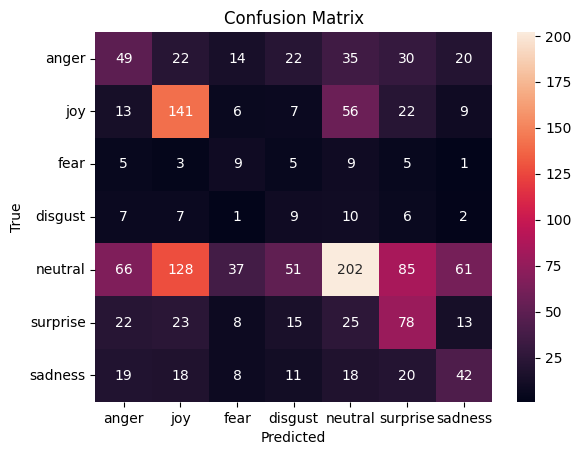

In [14]:
# confusion matrix
cm = confusion_matrix(val_true, val_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion2int.keys(), yticklabels=emotion2int.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Inference on Testing

In [15]:
model.eval()
test_pred = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        text_embeddings, attention_mask = batch['text_embeddings'].to(device), batch['attention_mask'].to(device)
        outputs = model(inputs_embeds=text_embeddings, attention_mask=attention_mask, labels=None)
        for b in range(len(outputs['logits'])):
            test_pred.extend(torch.argmax(outputs['logits'][b], 1).tolist())

100%|██████████| 665/665 [00:51<00:00, 13.03it/s]


In [16]:
count = 0
for i in range(len(test_data_pred)):
    for j in range(len(test_data_pred[i]['conversation'])):
        test_data_pred[i]['conversation'][j]['emotion'] = int2emotion[test_pred[count]]
        count += 1

In [17]:
json.dump(test_data_pred, open('test_conversation_level_pred.json', 'w'), indent=4)